
![title](test_images/meme.jpg)

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from tqdm import tqdm

%matplotlib inline
#%matplotlib qt


In [232]:
def setupinator(f_path, xy=(9,6)):
    objp = np.zeros((xy[0]*xy[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:xy[0], 0:xy[1]].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = [] 

    images = glob.glob(f_path)

    for idx, fname in tqdm(enumerate(images)):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (xy[0],xy[1]), None)
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            
    return objpoints, imgpoints

In [233]:
def cam_calibratinator(folder, file_name, save_name, test_name):

    img = cv2.imread(folder+test_name)
    img_size = (img.shape[1], img.shape[0])
    
    objpoints, imgpoints = setupinator(folder+file_name)
    
    ret, mtx, dist, rvecs, tvecs = cv2.cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    
    try:
        pickle.dump(dist_pickle, open( folder+save_name, "wb" ))
        print("Calibration was successful and saved!")
    except:
        print("Something went wrong")
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.imsave('output_images/undistorted1.jpg', dst)

In [234]:
from time import gmtime, strftime
t = strftime("%H%M", gmtime())
folder = 'camera_cal/'
f_names = 'calibration*.jpg'
s_name = 'calibrated-{}.p'.format(t)
t_name = 'calibration1.jpg'


0it [00:00, ?it/s]
1it [00:00,  2.17it/s]
2it [00:01,  1.86it/s]
4it [00:01,  2.15it/s]
7it [00:02,  2.56it/s]
10it [00:02,  3.49it/s]
14it [00:02,  4.70it/s]
16it [00:04,  2.81it/s]
17it [00:04,  2.05it/s]
20it [00:05,  3.99it/s]


Calibration was successful and saved!


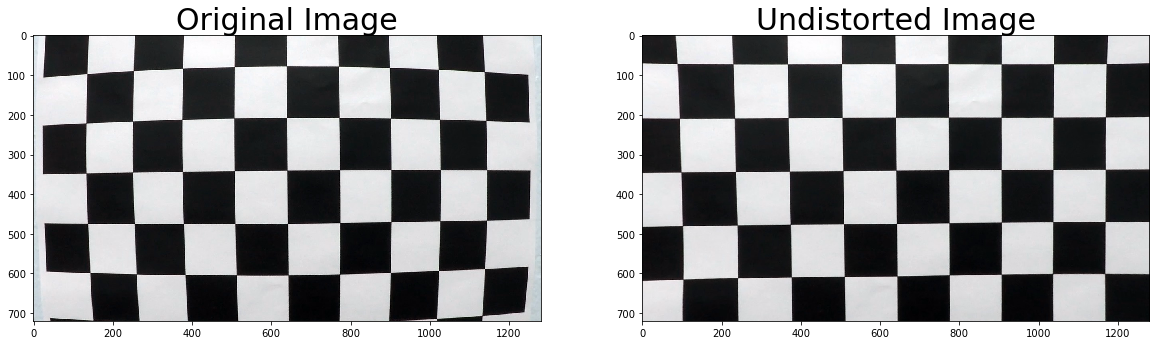

In [235]:
cam_calibratinator(folder, f_names, s_name, t_name)

In [195]:
def color_gradinator(img, s_thresh=(90, 255), sx_thresh=(50, 100)):
    img = np.copy(img)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    #sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobel = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))* 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

(720, 1280, 3) (720, 1280)


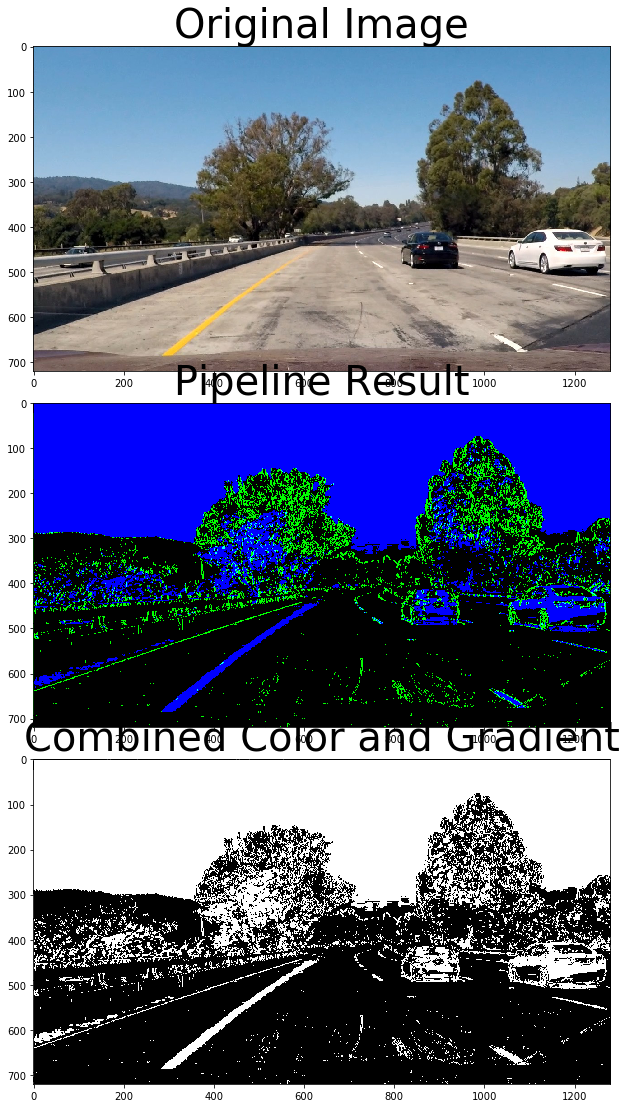

In [236]:
image = mpimg.imread('test_images/test1.jpg')
result, c_result = color_gradinator(image,s_thresh=(90, 255), sx_thresh=(20, 120))
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(40, 15))
f.tight_layout()
print(result.shape, c_result.shape)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)

ax3.imshow(c_result, cmap='gray')
ax3.set_title('Combined Color and Gradient', fontsize=40)
plt.imsave('output_images/test1.jpg', c_result, cmap='gray')
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [199]:
def change_of_basinator(p_file, image):
    dist_pickle = pickle.load( open( p_file, "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

    img_size = (image.shape[1], image.shape[0])
   
    undst = cv2.undistort(image, mtx, dist, None, mtx)
    src = np.float32([[890,560], [1050,660], [300,660], [450,560]])
    dst = np.float32([[1050,560], [1050,660], [300,660], [300,560]])
    
#     src = np.float32([[770,490], [1070,678], [320,678], [555,490]])
#     dst = np.float32([[1070,490], [1070,678], [320,6778], [320,4900]])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undst, M, img_size)
    
    return warped, M, undst

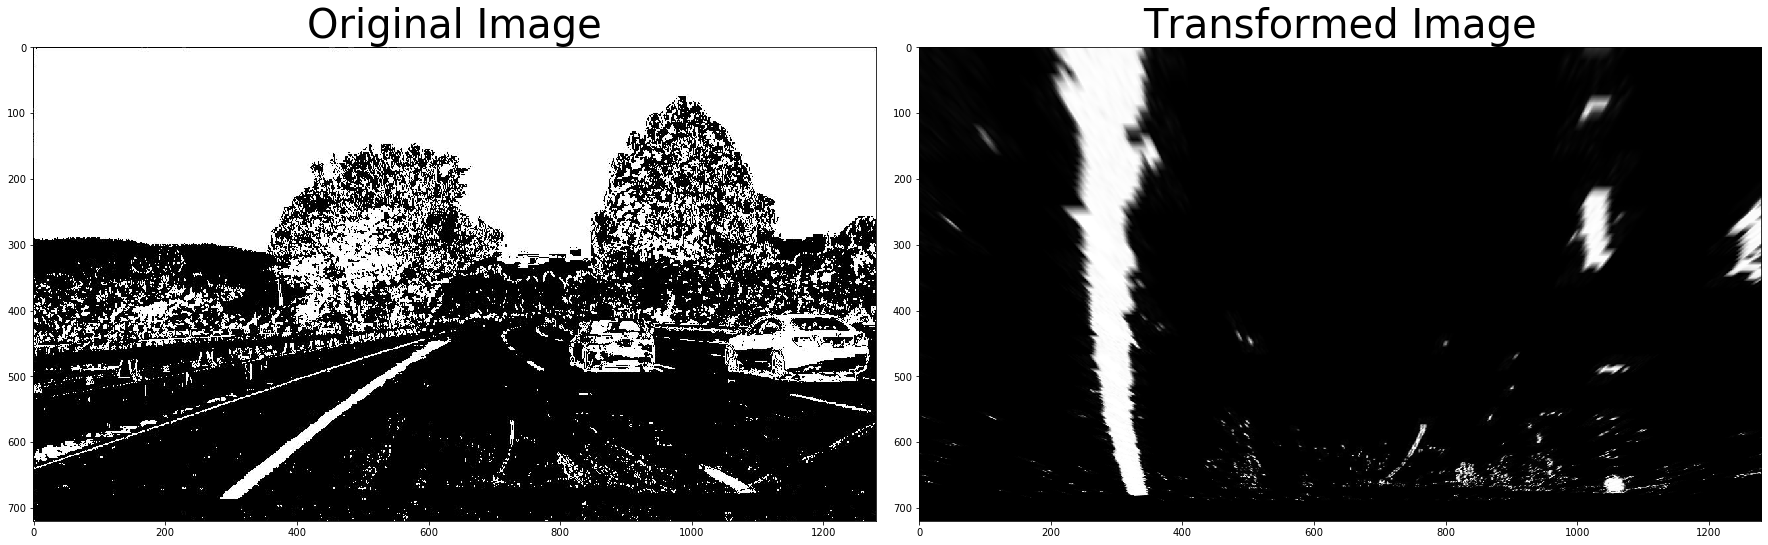

In [237]:
pickled_file = 'camera_cal/calibrated-1718.p'
test_img = 'output_images/test1.jpg'

image = mpimg.imread(test_img)
warped, M, undist = change_of_basinator(pickled_file, image)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Transformed Image', fontsize=40)
plt.imsave('output_images/test1-transformed.jpg', warped)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [103]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #sum of all xfits
        self.all_xfit = None
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #sum of all poly fits
        self.all_polyfit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]    
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #x fit counter
        self.xfit_counter = 0
        #poly fit counter
        self.polyfit_counter = 0
        
    def update_xfit(self, fit):        
        self.recent_xfitted = fit
        if self.xfit_counter == 0:
            self.all_xfit = fit
        else:
            self.all_xfit += fit
        self.xfit_counter += 1
        self.bestx = self.all_xfit/self.xfit_counter
            
            
    def update_polyfit(self, fit):        
        self.current_fit = fit
        if self.polyfit_counter == 0:
            self.all_polyfit = fit
        else:
            self.all_polyfit += fit
            self.diff = self.current_fit - fit
        self.polyfit_counter =+ 1
        self.best_fit = self.all_polyfit/self.polyfit_counter
            
        

In [144]:
def find_lane_pixelator(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    out_img = np.dstack((img, img, img))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    margin = 100
    minpix = 25

    window_height = np.int(img.shape[0]//nwindows)
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    left_line.line_base_pos = leftx_base
    right_line.line_base_pos = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = left_line.line_base_pos - margin
        win_xleft_high = left_line.line_base_pos + margin
        win_xright_low = right_line.line_base_pos - margin
        win_xright_high = right_line.line_base_pos + margin

        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            left_line.line_base_pos = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            right_line.line_base_pos = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
    
    left_line.allx = nonzerox[left_lane_inds]
    left_line.ally = nonzeroy[left_lane_inds] 
    right_line.allx = nonzerox[right_lane_inds]
    right_line.ally = nonzeroy[right_lane_inds]

    if sum(left_lane_inds.flatten()) == 0: 
        #Zero is not realistic because random objects on the road
        #could have a value and not be a lane. Could adjust this
        #value as a threshold. 
        left_line.detected = False
    else:
        left_line.detected = True
    
    if sum(right_lane_inds.flatten()) == 0:  
        right_line.detected = False
    else:
        right_line.detected = True
    
    return out_img

In [248]:
def curvinator(ploty, ym_per_pix=(3.048/96), xm_per_pix=(3.66/695)):
    #specs for highway lane could be found here:
    #https://mutcd.fhwa.dot.gov/htm/2003r1/part3/part3a.htm
    
    y_eval = np.max(ploty)
    
    left_fit = np.polyfit(left_line.ally*ym_per_pix, 
                            left_line.allx*xm_per_pix, 2)
    right_fit = np.polyfit(right_line.ally*ym_per_pix, 
                           right_line.allx*ym_per_pix, 2)
    
    if left_fit[0] != 0:
        left_line.radius_of_curvature = ((1 + (2*left_fit[0]*y_eval*ym_per_pix +
            left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    else:
        left_line.radius_of_curvature = 0
    
    if right_fit[0] != 0:
        right_line.radius_of_curvature = ((1 + (2*right_fit[0]*y_eval*ym_per_pix +
            right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    else:
        right_line.radius_of_curvature = 0

In [249]:

def poly_fitinator(img, ym_per_pix, xm_per_pix):
    out_img = find_lane_pixelator(img)
    try:
        left_line.update_polyfit(np.polyfit(left_line.ally*ym_per_pix, 
                                        left_line.allx*xm_per_pix, 2))
        right_line.update_polyfit(np.polyfit(right_line.ally*ym_per_pix, 
                                        right_line.allx*xm_per_pix, 2))
    except TypeError:
        left_line.update_polyfit(left_line.current_fit)
        right_line.update_polyfit(right_line.current_fit)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    try:
        left_line.update_xfit(left_line.current_fit[0]*ploty**2 + \
                    left_line.current_fit[1]*ploty + left_line.current_fit[2])
        right_line.update_xfit(right_line.current_fit[0]*ploty**2 + \
                     right_line.current_fit[1]*ploty + right_line.current_fit[2])
    except TypeError:
        print('The function failed to fit a line.')
        left_line.update_xfit(1*ploty**2 + 1*ploty)
        right_line.update_xfit(1*ploty**2 + 1*ploty)
    
    curvinator(ploty)
    
    out_img[left_line.ally, left_line.allx] = [255, 0, 0]
    out_img[right_line.ally, right_line.allx] = [0, 0, 255]
    
    plt.plot(left_line.recent_xfitted, ploty, color='yellow')
    plt.plot(right_line.recent_xfitted, ploty, color='yellow')
    
    return out_img, ploty


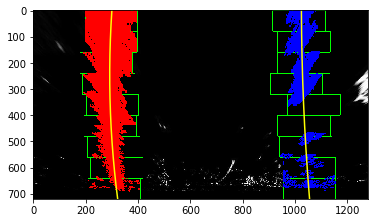

In [250]:
img = mpimg.imread('output_images/test1-transformed.jpg')
#image = mpimg.imread('test_images/test3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#image = cv2.imread('test3-transformed.jpg', cv2.IMREAD_GRAYSCALE)

left_line = Line()
right_line = Line()

out_img, ploty = poly_fitinator(gray, 1, 1)
plt.imshow(out_img)
plt.imsave('output_images/test1-fitted.jpg', out_img)


In [251]:
print("Right line radius of curvature is: ", right_line.radius_of_curvature)
print("Left line radius of curvature is: ", left_line.radius_of_curvature)

Right line radius of curvature is:  290.7539428938307
Left line radius of curvature is:  706.2802041389076


In [223]:
def pipe_lininator(image):
    calibrated = 'camera_cal/calibrated-1718.p'
    #image = mpimg.imread(img)    
    _, c_result = color_gradinator(image,s_thresh=(150, 255), 
                                        sx_thresh=(35, 110))
    warped, M, undist = change_of_basinator(calibrated, c_result)
    
    # Create an image to draw the lines on
    #warp = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    img, ploty = poly_fitinator(warped, 1, 1)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.recent_xfitted, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.recent_xfitted, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), False, (255,0,0), thickness=30)
    cv2.polylines(color_warp, np.int32([pts_right]), False, (255,0,0), thickness=30)
    

    Minv = -np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 1, 0)
    
    return result

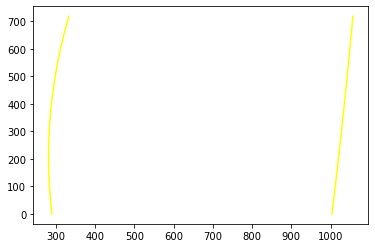

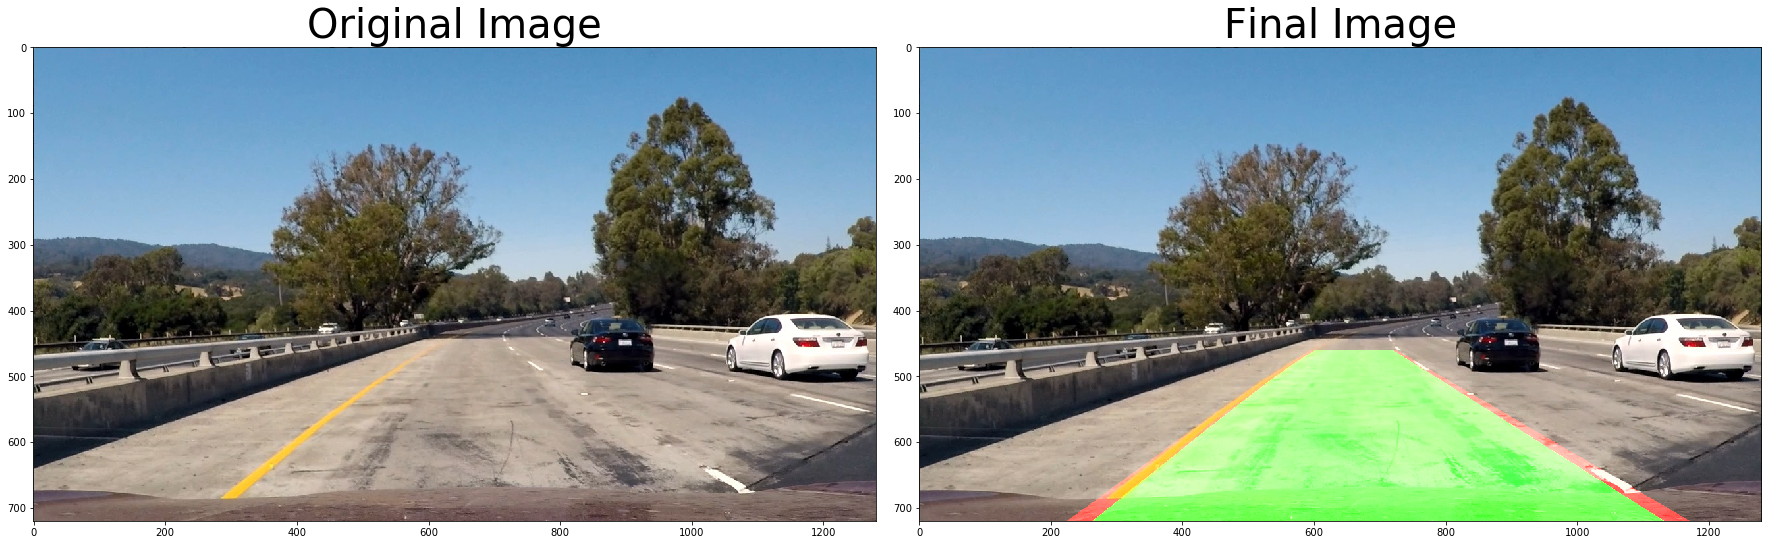

In [239]:
#calibrated_file = 'camera_cal/calibrated-1718.p'
img_path = 'test_images/test1.jpg'
image = mpimg.imread(img_path)

left_line = Line()
right_line = Line()


result = pipe_lininator(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Final Image', fontsize=40)
plt.imsave('output_images/test1-final.jpg', result)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# cv2.imshow("img",result)
# cv2.waitKey(0)  

In [120]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [225]:
left_line = Line()
right_line = Line()

def process_image(img):
    result = pipe_lininator(img)
    return result


t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/project_video_out.mp4.
Moviepy - Writing video test_videos_output/project_video_out.mp4




t:   5%|███▌                                                               | 67/1260 [00:10<02:52,  6.92it/s, now=None]


t:  11%|██████▉                                                           | 133/1260 [00:19<02:36,  7.18it/s, now=None]


t:  16%|██████████▍                                                       | 199/1260 [00:29<02:24,  7.32it/s, now=None]


t:  21%|█████████████▉                                                    | 265/1260 [00:38<02:27,  6.74it/s, now=None]


t:  26%|█████████████████▎                                                | 331/1260 [00:48<02:08,  7.23it/s, now=None]


t:  32%|████████████████████▊                                             | 397/1260 [00:57<02:09,  6.65it/s, now=None]


t:  37%|████████████████████████▎                                         | 463/1260 [01:07<01:50,  7.19it/s, now=None]


t:  42%|███████████████████████████▋                                      | 529/1260 [01:17<01:41,  7.22it/s, now=None]


t:  47%|███████████████████████████████▏                                  | 595/1260 [01:26<01:29,  7.43it/s, now=None]


t:  52%|██████████████████████████████████▌                               | 661/1260 [01:35<01:27,  6.87it/s, now=None]


t:  58%|██████████████████████████████████████                            | 727/1260 [01:45<01:13,  7.22it/s, now=None]


t:  63%|█████████████████████████████████████████▌                        | 793/1260 [01:55<01:07,  6.89it/s, now=None]


t:  68%|████████████████████████████████████████████▉                     | 859/1260 [02:05<01:03,  6.31it/s, now=None]


t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [02:14<00:49,  6.76it/s, now=None]


t:  79%|███████████████████████████████████████████████████▉              | 991/1260 [02:24<00:38,  6.99it/s, now=None]


t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [02:34<00:30,  6.57it/s, now=None]


t:  89%|█████████████████████████████████████████████████████████▉       | 1123/1260 [02:44<00:20,  6.67it/s, now=None]


t:  94%|█████████████████████████████████████████████████████████████▎   | 1189/1260 [02:54<00:10,  6.75it/s, now=None]


t: 100%|████████████████████████████████████████████████████████████████▋| 1255/1260 [03:04<00:00,  6.36it/s, now=None]


t:  21%|█████████████▉                                                   | 104/485 [1:59:27<00:47,  8.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/project_video_out.mp4
Wall time: 3min 6s


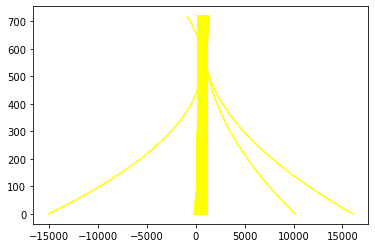

In [226]:
white_output = 'test_videos_output/project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [227]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))